# Naive Bayes — TensorFlow (CPU)

Two-part pipeline implementing both Naive Bayes variants using TensorFlow tensors on CPU.

**Part 1: GaussianNB** (Breast Cancer — binary classification baseline)
- 455 train / 114 test samples, 30 continuous features, 2 classes
- Gaussian likelihood via `tf.math`, log-sum-exp via `tf.reduce_logsumexp()`

**Part 2: MultinomialNB** (20 Newsgroups — text classification main event)
- 11,314 train / 7,532 test documents, 10,000 TF-IDF features, 20 categories
- Matmul prediction: `X @ tf.transpose(feature_log_prob) + class_log_prior`

**Showcase**: `tf.function` — comparing eager execution vs graph-compiled execution. TensorFlow's defining feature: compiling Python into optimized static computation graphs.

**Note**: TF 2.11+ dropped native Windows GPU support. This pipeline runs on CPU. GPU acceleration via WSL2 is planned for neural network models.

In [1]:
# Step 1: Imports and setup
import sys
import os
import time
import numpy as np
import tensorflow as tf

# Add project root to path for utils
sys.path.insert(0, os.path.abspath('../..'))
from utils.data_loader import load_processed_data
from utils.performance import track_performance, track_inference, get_model_size
from utils.metrics import evaluate_classifier, print_metrics
from utils.visualization import (plot_calibration_curve, plot_confusion_matrix,
                                  plot_confusion_matrix_multiclass, plot_per_class_f1)
from utils.results import save_results, add_result, print_comparison

# Configuration
RANDOM_STATE = 113
ALPHA = 1.0            # Laplace smoothing for MultinomialNB
VAR_SMOOTHING = 1e-9   # Variance floor for GaussianNB
FRAMEWORK = 'TensorFlow'

# Device info
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow {tf.__version__}")
print(f"GPUs available: {len(gpus)} {'(CPU only)' if not gpus else gpus}")

# Load both datasets (numpy arrays)
X_train_g, X_test_g, y_train_g, y_test_g, meta_g = load_processed_data('naive_bayes_gaussian')
X_train_t, X_test_t, y_train_t, y_test_t, meta_t = load_processed_data('naive_bayes_text')

# Convert to TF constants
# GaussianNB: float64 to match numpy precision (same fix as PyTorch)
X_train_g_t = tf.constant(X_train_g, dtype=tf.float64)
X_test_g_t = tf.constant(X_test_g, dtype=tf.float64)
# MultinomialNB: float32 (standard for TF ops)
X_train_t_t = tf.constant(X_train_t, dtype=tf.float32)
X_test_t_t = tf.constant(X_test_t, dtype=tf.float32)

# Labels as TF constants
y_train_g_t = tf.constant(y_train_g, dtype=tf.int32)
y_train_t_t = tf.constant(y_train_t, dtype=tf.int32)

print(f"\n{'=' * 60}")
print(f"NAIVE BAYES — {FRAMEWORK}")
print("=" * 60)
print(f"\nPart 1: Breast Cancer (GaussianNB)")
print(f"  Training: {X_train_g_t.shape[0]} samples, {X_train_g_t.shape[1]} features")
print(f"  Test:     {X_test_g_t.shape[0]} samples")
print(f"  Classes:  {meta_g['n_classes']} ({meta_g['class_names']})")
print(f"\nPart 2: 20 Newsgroups (MultinomialNB)")
print(f"  Training: {X_train_t_t.shape[0]:,} samples, {X_train_t_t.shape[1]:,} features")
print(f"  Test:     {X_test_t_t.shape[0]:,} samples")
print(f"  Classes:  {meta_t['n_classes']} categories")

TensorFlow 2.20.0
GPUs available: 0 (CPU only)

NAIVE BAYES — TensorFlow

Part 1: Breast Cancer (GaussianNB)
  Training: 455 samples, 30 features
  Test:     114 samples
  Classes:  2 (['malignant', 'benign'])

Part 2: 20 Newsgroups (MultinomialNB)
  Training: 11,314 samples, 10,000 features
  Test:     7,532 samples
  Classes:  20 categories



METRICS — GaussianNB — Breast Cancer
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.9385       0.8947
precision                       0.9509       0.9054
recall                          0.9509       0.9306
f1                              0.9509       0.9178
auc                             0.9592       0.9363
log_loss                        0.7158       1.0123
brier_score                     0.0608       0.0983
ece                             0.3681       0.3590


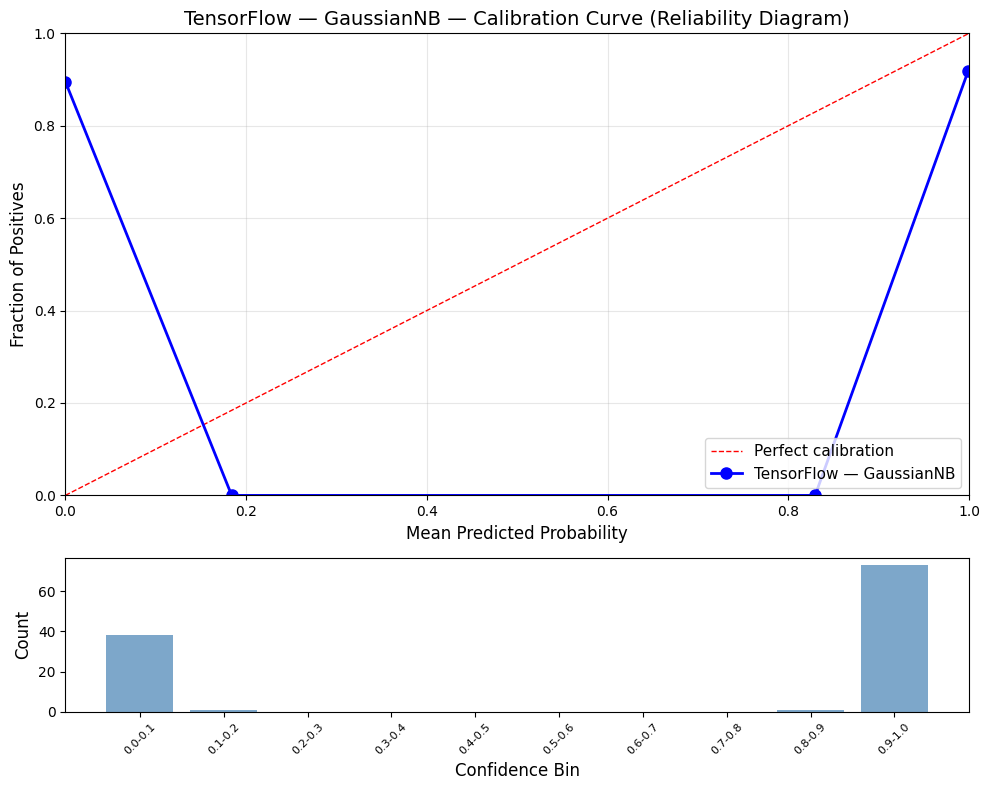

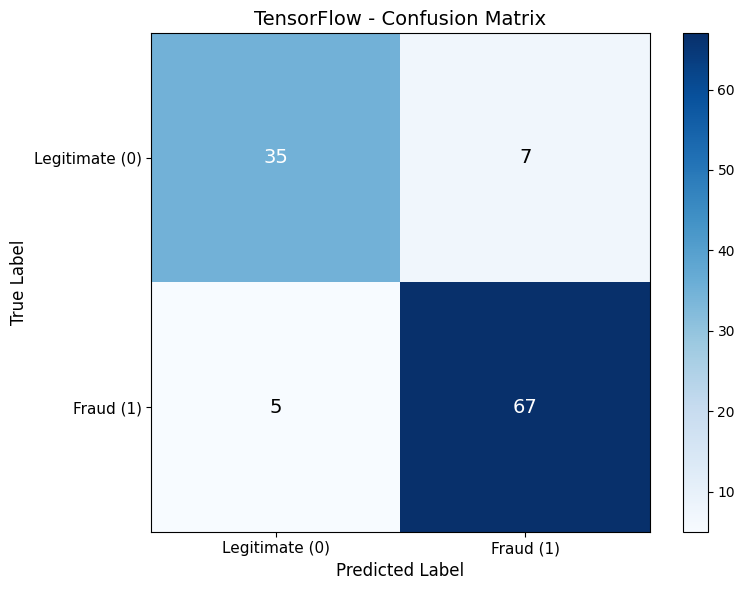


GaussianNB baseline complete.
Key takeaway: 89.5% accuracy, ECE=0.3590


In [2]:
# Step 2: GaussianNB — train, predict, evaluate (Breast Cancer baseline)
def gaussian_nb_train_tf(X, y):
    """
    Train GaussianNB using TensorFlow tensors on CPU.

    Same math as other frameworks: per-class means, variances (+ smoothing),
    and log priors. Uses tf.boolean_mask for class selection, tf.stack to
    build parameter tensors (TF tensors are immutable — no in-place assignment).

    Args:
        X: Training features (n_samples, n_features) tf.Tensor.
        y: Training labels (n_samples,) tf.Tensor (int32).

    Returns:
        dict: Model parameters as TF tensors.
    """
    classes = tf.sort(tf.unique(y)[0])  # tf.unique returns (values, indices) — sort for consistency
    n_classes = len(classes)
    n_samples = X.shape[0]

    class_means_list = []
    class_vars_list = []
    class_log_prior_list = []

    for k in range(n_classes):
        cls = classes[k]
        X_k = tf.boolean_mask(X, tf.equal(y, cls))  # select samples for class k

        class_means_list.append(tf.reduce_mean(X_k, axis=0))
        # tf.math.reduce_variance computes population variance by default (no unbiased flag)
        class_vars_list.append(tf.math.reduce_variance(X_k, axis=0) + VAR_SMOOTHING)

        n_k = tf.cast(tf.shape(X_k)[0], X.dtype)
        class_log_prior_list.append(tf.math.log(n_k / tf.cast(n_samples, X.dtype)))

    return {
        'classes': classes,
        'class_means': tf.stack(class_means_list),       # (n_classes, n_features)
        'class_vars': tf.stack(class_vars_list),          # (n_classes, n_features)
        'class_log_prior': tf.stack(class_log_prior_list) # (n_classes,)
    }

def gaussian_nb_predict_tf(model, X):
    """
    Predict with GaussianNB on CPU.

    Gaussian log-likelihood per feature, summed across features.
    Uses tf.reduce_logsumexp() for numerically stable softmax (built-in!).
    Builds log_posteriors via list + tf.stack (immutable tensors).

    Args:
        model: Dict from gaussian_nb_train_tf().
        X: Features (n_samples, n_features) tf.Tensor.

    Returns:
        y_pred: Predicted labels (n_samples,) tf.Tensor.
        y_proba: Class probabilities (n_samples, n_classes) tf.Tensor.
    """
    classes = model['classes']
    means = model['class_means']
    variances = model['class_vars']
    log_prior = model['class_log_prior']

    n_classes = len(classes)
    log_posteriors_list = []

    for k in range(n_classes):
        # Gaussian log-likelihood: -0.5 * (log(2*pi*var) + (x - mean)^2 / var)
        log_lik = -0.5 * (
            tf.math.log(2.0 * np.pi * variances[k])
            + (X - means[k]) ** 2 / variances[k]
        )
        log_posteriors_list.append(log_prior[k] + tf.reduce_sum(log_lik, axis=1))

    log_posteriors = tf.stack(log_posteriors_list, axis=1)  # (n_samples, n_classes)

    # tf.gather replaces PyTorch's classes[argmax] indexing
    y_pred = tf.gather(classes, tf.argmax(log_posteriors, axis=1))

    # tf.reduce_logsumexp — TF's built-in log-sum-exp (numerically stable)
    log_norm = tf.reduce_logsumexp(log_posteriors, axis=1)
    y_proba = tf.exp(log_posteriors - tf.expand_dims(log_norm, axis=1))

    return y_pred, y_proba

# Train + evaluate
gnb_model = gaussian_nb_train_tf(X_train_g_t, y_train_g_t)

train_pred_g, train_proba_g = gaussian_nb_predict_tf(gnb_model, X_train_g_t)
test_pred_g, test_proba_g = gaussian_nb_predict_tf(gnb_model, X_test_g_t)

# .numpy() to convert for evaluation utils (TF eager mode — no .cpu() needed)
train_metrics_g = evaluate_classifier(
    y_train_g, train_pred_g.numpy(), train_proba_g[:, 1].numpy())
test_metrics_g = evaluate_classifier(
    y_test_g, test_pred_g.numpy(), test_proba_g[:, 1].numpy())
print_metrics(train_metrics_g, test_metrics_g, title='GaussianNB — Breast Cancer')

# Visualizations
plot_calibration_curve(y_test_g, test_proba_g[:, 1].numpy(),
                       f'{FRAMEWORK} — GaussianNB',
                       save_path='results/gaussian_calibration.png')

plot_confusion_matrix(y_test_g, test_pred_g.numpy(), FRAMEWORK,
                      save_path='results/gaussian_confusion_matrix.png')

print(f"\nGaussianNB baseline complete.")
print(f"Key takeaway: {test_metrics_g['accuracy']:.1%} accuracy, "
      f"ECE={test_metrics_g['ece']:.4f}")

## Part 2: MultinomialNB — 20 Newsgroups Text Classification

MultinomialNB models each class as a multinomial distribution over vocabulary terms. Prediction is a single matrix multiply: `X @ tf.transpose(feature_log_prob) + class_log_prior` — all TF tensor operations on CPU.

**Key TensorFlow details:**
- Feature log-probs and class priors stored as `tf.constant` tensors (float32, immutable)
- `tf.reduce_logsumexp()` for numerically stable softmax (built-in, no manual implementation)
- `tf.boolean_mask()` replaces NumPy boolean indexing for class-wise feature extraction
- Showcase: `tf.function` wraps the predict function into a compiled graph for benchmarking

In [5]:
# Step 3: MultinomialNB — train (20 Newsgroups)
def multinomial_nb_train_tf(X, y, alpha=ALPHA):
    """
    Train MultinomialNB using TensorFlow tensors on CPU.

    Laplace-smoothed log-probabilities for each feature per class.
    Same list + tf.stack pattern as GaussianNB (immutable tensors).

    Args:
        X: Training features (n_samples, n_features) tf.Tensor (float32).
        y: Training labels (n_samples,) tf.Tensor (int32).
        alpha: Laplace smoothing parameter (default 1.0).

    Returns:
        dict: Model parameters — feature_log_prob, class_log_prior, classes.
    """
    classes = tf.sort(tf.unique(y)[0])
    n_classes = len(classes)
    n_samples = X.shape[0]
    n_features = X.shape[1]

    feature_log_prob_list = []
    class_log_prior_list = []

    for k in range(n_classes):
        cls = classes[k]
        X_k = tf.boolean_mask(X, tf.equal(y, cls))

        # Laplace-smoothed log-probabilities
        feature_counts = tf.reduce_sum(X_k, axis=0)           # (n_features,)
        total_count = tf.reduce_sum(feature_counts)            # scalar
        log_prob = tf.math.log(
            (feature_counts + alpha) / (total_count + alpha * tf.cast(n_features, X.dtype))
        )
        feature_log_prob_list.append(log_prob)

        n_k = tf.cast(tf.shape(X_k)[0], X.dtype)
        class_log_prior_list.append(tf.math.log(n_k / tf.cast(n_samples, X.dtype)))

    return {
        'classes': classes,
        'feature_log_prob': tf.stack(feature_log_prob_list),   # (n_classes, n_features)
        'class_log_prior': tf.stack(class_log_prior_list)      # (n_classes,)
    }


# Train with performance tracking (CPU only — no gpu=True)
with track_performance() as perf_t:
    mnb_model = multinomial_nb_train_tf(X_train_t_t, y_train_t_t, alpha=ALPHA)

print("=" * 60)
print("MULTINOMIAL NB — TRAINING COMPLETE")
print("=" * 60)
print(f"  Alpha (Laplace smoothing): {ALPHA}")
print(f"  Training time: {perf_t['time']:.4f}s")
print(f"  Peak memory:   {perf_t['memory']:.2f} MB")
print(f"  Classes: {len(mnb_model['classes'])}")
print(f"  Feature log-probs shape: {mnb_model['feature_log_prob'].shape}")
print(f"    (20 classes x 10,000 vocabulary terms)")
print(f"  dtype: {mnb_model['feature_log_prob'].dtype}")

MULTINOMIAL NB — TRAINING COMPLETE
  Alpha (Laplace smoothing): 1.0
  Training time: 0.0691s
  Peak memory:   0.06 MB
  Classes: 20
  Feature log-probs shape: (20, 10000)
    (20 classes x 10,000 vocabulary terms)
  dtype: <dtype: 'float32'>


In [6]:
# Step 4: MultinomialNB — predict, evaluate, inference timing, model size
def multinomial_nb_predict_tf(model, X):
    """
    Predict with MultinomialNB on CPU.

    The big matmul: X @ tf.transpose(feature_log_prob) + class_log_prior
    Shape: (n_samples, 10000) @ (10000, 20) = (n_samples, 20)

    Args:
        model: Dict from multinomial_nb_train_tf().
        X: Features (n_samples, n_features) tf.Tensor.

    Returns:
        y_pred: Predicted labels (n_samples,) tf.Tensor.
        y_proba: Class probabilities (n_samples, n_classes) tf.Tensor.
    """
    classes = model['classes']
    feature_log_prob = model['feature_log_prob']
    log_prior = model['class_log_prior']

    # The big matmul — tf.transpose replaces PyTorch's .T
    log_posteriors = X @ tf.transpose(feature_log_prob) + log_prior

    # Predictions: tf.gather replaces PyTorch's classes[argmax] indexing
    y_pred = tf.gather(classes, tf.argmax(log_posteriors, axis=1))

    # Probabilities: tf.reduce_logsumexp (built-in, numerically stable)
    log_norm = tf.reduce_logsumexp(log_posteriors, axis=1)
    y_proba = tf.exp(log_posteriors - tf.expand_dims(log_norm, axis=1))

    return y_pred, y_proba


# Full predictions
train_pred_t, train_proba_t = multinomial_nb_predict_tf(mnb_model, X_train_t_t)
test_pred_t, test_proba_t = multinomial_nb_predict_tf(mnb_model, X_test_t_t)

# .numpy() directly — no .cpu() needed on CPU
train_metrics_t = evaluate_classifier(
    y_train_t, train_pred_t.numpy(), train_proba_t.numpy())
test_metrics_t = evaluate_classifier(
    y_test_t, test_pred_t.numpy(), test_proba_t.numpy())
print_metrics(train_metrics_t, test_metrics_t, title='MultinomialNB — 20 Newsgroups')

# Inference speed — lambda wraps TF predict + numpy conversion
def predict_for_timing(X_np):
    X_tf = tf.constant(X_np, dtype=tf.float32)
    pred, _ = multinomial_nb_predict_tf(mnb_model, X_tf)
    return pred.numpy()

inference_stats = track_inference(predict_for_timing, X_test_t)

# Model size — convert to numpy dict for get_model_size
model_params_np = {
    'feature_log_prob': mnb_model['feature_log_prob'].numpy(),
    'class_log_prior': mnb_model['class_log_prior'].numpy()
}
model_size = get_model_size(model_params_np, framework='numpy')

print(f"\nPerformance:")
print(f"  Inference: {inference_stats['per_sample_us']:.2f} μs/sample "
      f"({inference_stats['samples_per_sec']:,.0f} samples/sec)")
print(f"  Model size: {model_size / (1024 ** 2):.4f} MB")


METRICS — MultinomialNB — 20 Newsgroups
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.8367       0.6683
macro_f1                        0.8194       0.6394
log_loss                        1.1388       1.5576
brier_score                     0.4553       0.6008
ece                             0.4015       0.3229

Performance:
  Inference: 7.05 μs/sample (141,872 samples/sec)
  Model size: 0.7630 MB


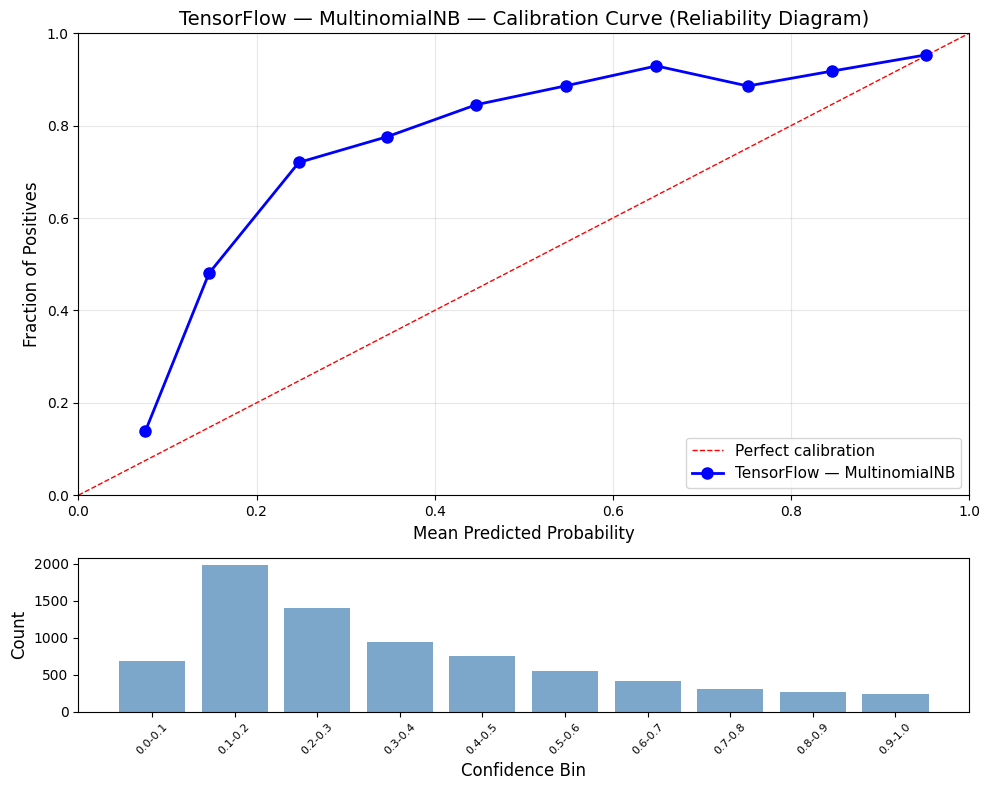

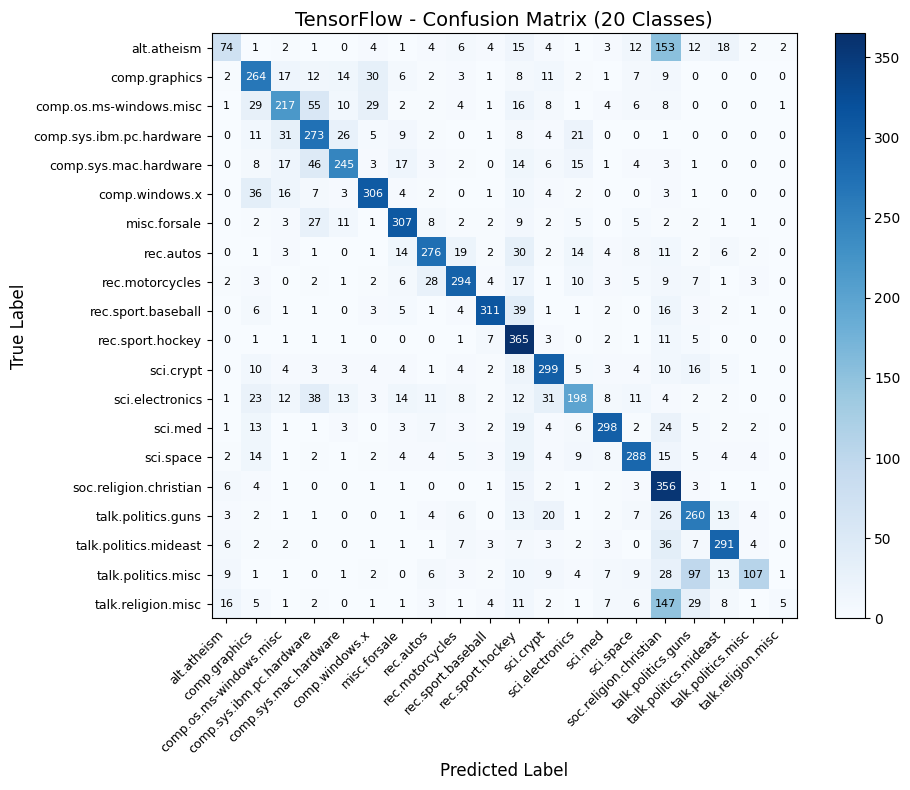

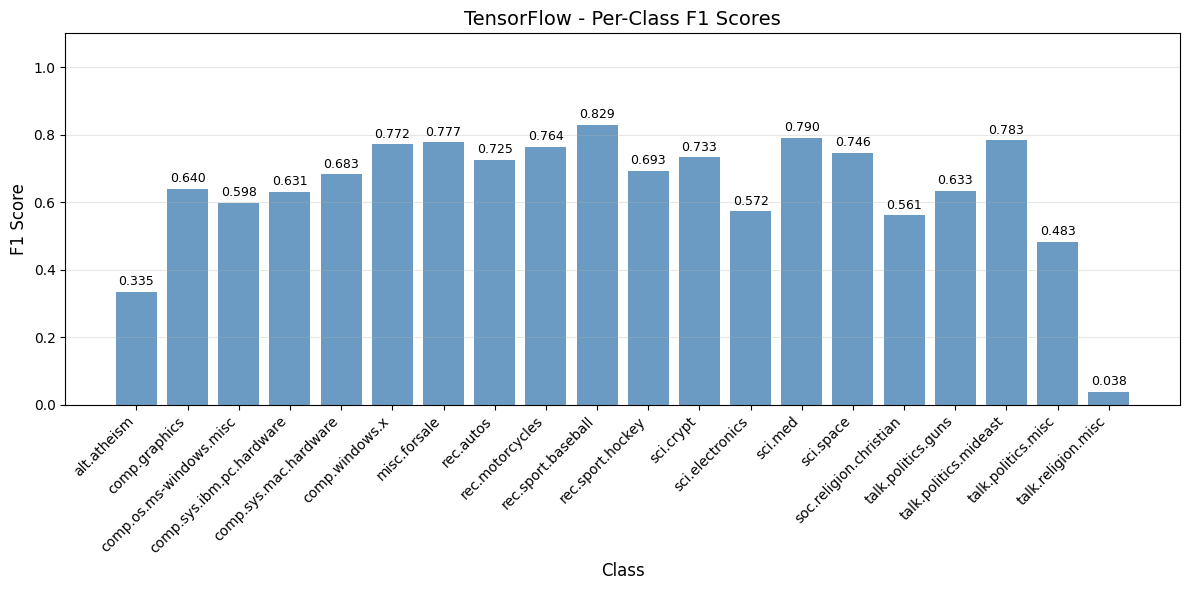

MultinomialNB evaluation complete.
Key: 66.8% accuracy, ECE=0.3229


In [7]:
# Step 5: MultinomialNB — visualizations
class_names = meta_t['class_names']

plot_calibration_curve(y_test_t, test_proba_t.numpy(),
                       f'{FRAMEWORK} — MultinomialNB', n_bins=10,
                       save_path='results/multinomial_calibration.png')

plot_confusion_matrix_multiclass(y_test_t, test_pred_t.numpy(), class_names, FRAMEWORK,
                                  save_path='results/multinomial_confusion_matrix.png')

plot_per_class_f1(y_test_t, test_pred_t.numpy(), class_names, FRAMEWORK,
                  save_path='results/multinomial_per_class_f1.png')

print(f"MultinomialNB evaluation complete.")
print(f"Key: {test_metrics_t['accuracy']:.1%} accuracy, ECE={test_metrics_t['ece']:.4f}")